# Installation Script

In [ ]:
# Install condacolab
!pip install -q condacolab

# Import and install Conda using condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:06
🔁 Restarting kernel...


In [ ]:
# Update Conda to the latest version
!conda update -n base -c defaults conda -y

Channels:
 - defaults
 - conda-forge
Platform: linux-64
Solving environment: - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.7.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.7.2   |       h06a4308_0         127 KB
    certifi-2024.8.30          |  py310h06a4308_0         162 KB
    conda-23.11.0              |  py310h06a4308_0         997 KB
    ------------------------------------------------------------
                                           Total:         1.3 MB

The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2023.11.~ --> pkgs/main::ca-certificates-2024.7.2-h06a4308_0 


In [ ]:
# Install Pyomo, Bonmin, Ipopt, and CBC from the conda-forge channel
!conda install -c conda-forge pyomo coin-or-bonmin coincbc ipopt -y > /dev/null 2>&1

# Install IDAES
!pip install -q idaes-pse --pre > /dev/null 2>&1

# Install the IDAES solver binaries, including Couenne
!idaes get-extensions --to /usr/local/bin > /dev/null 2>&1

In [ ]:
import shutil

# Verify Pyomo installation
pyomo_path = shutil.which("pyomo")
print(f"Pyomo path: {pyomo_path}")

# Verify Bonmin installation
bonmin_path = shutil.which("bonmin")
print(f"Bonmin path: {bonmin_path}")

# Verify IPOPT installation
ipopt_path = shutil.which("ipopt")
print(f"IPOPT path: {ipopt_path}")

# Verify CBC installation
cbc_path = shutil.which("cbc")
print(f"CBC path: {cbc_path}")

# Verify Couenne installation
couenne_path = shutil.which("couenne")
print(f"Couenne path: {couenne_path}")

Pyomo path: /usr/local/bin/pyomo
Bonmin path: /usr/local/bin/bonmin
IPOPT path: /usr/local/bin/ipopt
CBC path: /usr/local/bin/cbc
Couenne path: /usr/local/bin/couenne


# Testing Script

In [ ]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory, TerminationCondition

print("Pyomo imported successfully!")

# Define a simple MINLP model to test Bonmin
model = pyo.ConcreteModel()

# Variables
model.x = pyo.Var(within=pyo.NonNegativeReals)
model.y = pyo.Var(within=pyo.Binary)

# Objective: Minimize x
model.obj = pyo.Objective(expr = model.x, sense=pyo.minimize)

# Constraint: x >= 2 + y
model.con1 = pyo.Constraint(expr = model.x >= 2 + model.y)

# Create Bonmin solver
solver = SolverFactory('bonmin')

# Check if Bonmin is available
if not solver.available():
    raise Exception("Bonmin solver is not available.")

# Solve the model
results = solver.solve(model, tee=True)

# Display results
model.display()

Pyomo imported successfully!
Bonmin 1.8.8 using Cbc 2.10.10 and Ipopt 3.13.2
bonmin: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fo

# MINLP Script

## Data Generation

In [ ]:
import random
import math
import pandas as pd
import pyomo.environ as pyo
from pyomo.opt import SolverFactory, TerminationCondition
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
# Parameters for the chip
CHIP_WIDTH = 100
CHIP_HEIGHT = 100

# Number of components
NUM_COMPONENTS = 10

# Generate synthetic data for components
components = pd.DataFrame({
    'Component': [f'C{i}' for i in range(1, NUM_COMPONENTS + 1)],
    'Width': [random.randint(5, 15) for _ in range(NUM_COMPONENTS)],
    'Height': [random.randint(5, 15) for _ in range(NUM_COMPONENTS)],
})

print("Synthetic Components Data:")
display(components)

Synthetic Components Data:


,Component,Width,Height
0,C1,8,8
1,C2,12,9
2,C3,10,8
3,C4,8,9
4,C5,8,7
5,C6,9,9
6,C7,7,9
7,C8,9,9
8,C9,7,13
9,C10,10,12


## Model Creation

In [ ]:
# Define the optimization model
model = pyo.ConcreteModel()

# Sets
model.Components = pyo.Set(initialize=components['Component'])
model.Pairs = pyo.Set(initialize=[(i, j) for i in components['Component'] for j in components['Component'] if i < j])

# Parameters
component_width = components.set_index('Component')['Width'].to_dict()
component_height = components.set_index('Component')['Height'].to_dict()

model.Width = pyo.Param(model.Components, initialize=component_width)
model.Height = pyo.Param(model.Components, initialize=component_height)

# Variables: Lower-left corner positions
model.x = pyo.Var(model.Components, within=pyo.NonNegativeReals, bounds=(0, CHIP_WIDTH))
model.y = pyo.Var(model.Components, within=pyo.NonNegativeReals, bounds=(0, CHIP_HEIGHT))

# Provide initial guesses for x and y variables to help solver
for comp in model.Components:
    model.x[comp].value = random.uniform(0, CHIP_WIDTH)
    model.y[comp].value = random.uniform(0, CHIP_HEIGHT)

# Binary variables for non-overlapping constraints
model.delta = pyo.Var(model.Pairs, within=pyo.Binary)

# Objective: Minimize total wire length (sum of distances between component centers)
# For simplicity, assume each component is connected to the next one
connections = [(components['Component'][i], components['Component'][i+1]) for i in range(NUM_COMPONENTS - 1)]
model.Connections = pyo.Set(initialize=connections)

# Epsilon to avoid sqrt(0) issues
epsilon = 1e-8

def wire_length_rule(model):
    return sum(
        ((model.x[i] + model.Width[i]/2 - model.x[j] - model.Width[j]/2)**2 +
         (model.y[i] + model.Height[i]/2 - model.y[j] - model.Height[j]/2)**2 + epsilon)**0.5
        for (i, j) in model.Connections
    )
model.WireLength = pyo.Objective(rule=wire_length_rule, sense=pyo.minimize)

# Big-M constant based on maximum component size
M = max(components['Width'].max(), components['Height'].max()) * 2

# Non-overlapping constraints
def no_overlap_rule_1(model, i, j):
    # Rectangle i to the left of j
    return model.x[i] + model.Width[i] <= model.x[j] + M * (1 - model.delta[i,j])

def no_overlap_rule_2(model, i, j):
    # Rectangle j to the left of i
    return model.x[j] + model.Width[j] <= model.x[i] + M * model.delta[i,j]

# Apply the no overlap constraints
model.NoOverlap_1 = pyo.Constraint(model.Pairs, rule=no_overlap_rule_1)
model.NoOverlap_2 = pyo.Constraint(model.Pairs, rule=no_overlap_rule_2)

# Ensure components stay within chip boundaries
def within_chip_x(model, i):
    return model.x[i] + model.Width[i] <= CHIP_WIDTH
model.WithinChipX = pyo.Constraint(model.Components, rule=within_chip_x)

def within_chip_y(model, i):
    return model.y[i] + model.Height[i] <= CHIP_HEIGHT
model.WithinChipY = pyo.Constraint(model.Components, rule=within_chip_y)

# Display model
model.pprint()

3 Set Declarations
    Components : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10'}
    Connections : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :    9 : {('C1', 'C2'), ('C2', 'C3'), ('C3', 'C4'), ('C4', 'C5'), ('C5', 'C6'), ('C6', 'C7'), ('C7', 'C8'), ('C8', 'C9'), ('C9', 'C10')}
    Pairs : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :   45 : {('C1', 'C2'), ('C1', 'C3'), ('C1', 'C4'), ('C1', 'C5'), ('C1', 'C6'), ('C1', 'C7'), ('C1', 'C8'), ('C1', 'C9'), ('C1', 'C10'), ('C2', 'C3'), ('C2', 'C4'), ('C2', 'C5'), ('C2', 'C6'), ('C2', 'C7'), ('C2', 'C8'), ('C2', 'C9'), ('C3', 'C4'), ('C3', 'C5'), ('C3', 'C6'), ('C3', 'C7'), ('C3', 'C8'), ('C3', 'C9'), ('C4', 'C5'), ('C4', 'C6'), ('C4', 'C7'), ('C4', 'C8'), ('C4',

## Solver Execution

In [ ]:
# Create a function to attempt solving with multiple solvers
def solve_with_fallback(model, solvers):
    # Try each solver in order
    for solver_name in solvers:
        print(f"Trying solver: {solver_name}")
        solver = SolverFactory(solver_name)
        if solver.available():
            try:
                results = solver.solve(model, tee=True)
                # Check if the solver terminated successfully
                if (results.solver.termination_condition == TerminationCondition.optimal or
                    results.solver.termination_condition == TerminationCondition.feasible):
                    print(f"Solver {solver_name} succeeded!")
                    return results  # Successful solution
                else:
                    print(f"Solver {solver_name} failed with termination condition: {results.solver.termination_condition}")
            except Exception as e:
                print(f"Solver {solver_name} encountered an error: {e}")
        else:
            print(f"Solver {solver_name} is not available.")
    # If no solver succeeded
    raise Exception("All solvers failed.")

# List of solvers to try
solvers_to_try = ['bonmin', 'couenne', 'ipopt', 'cbc']

# Solve the model using fallback mechanism
results = solve_with_fallback(model, solvers_to_try)

# Display the results
model.display()

Trying solver: bonmin
Bonmin 1.8.8 using Cbc 2.10.10 and Ipopt 3.13.2
bonmin: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran c

## Plotting Results

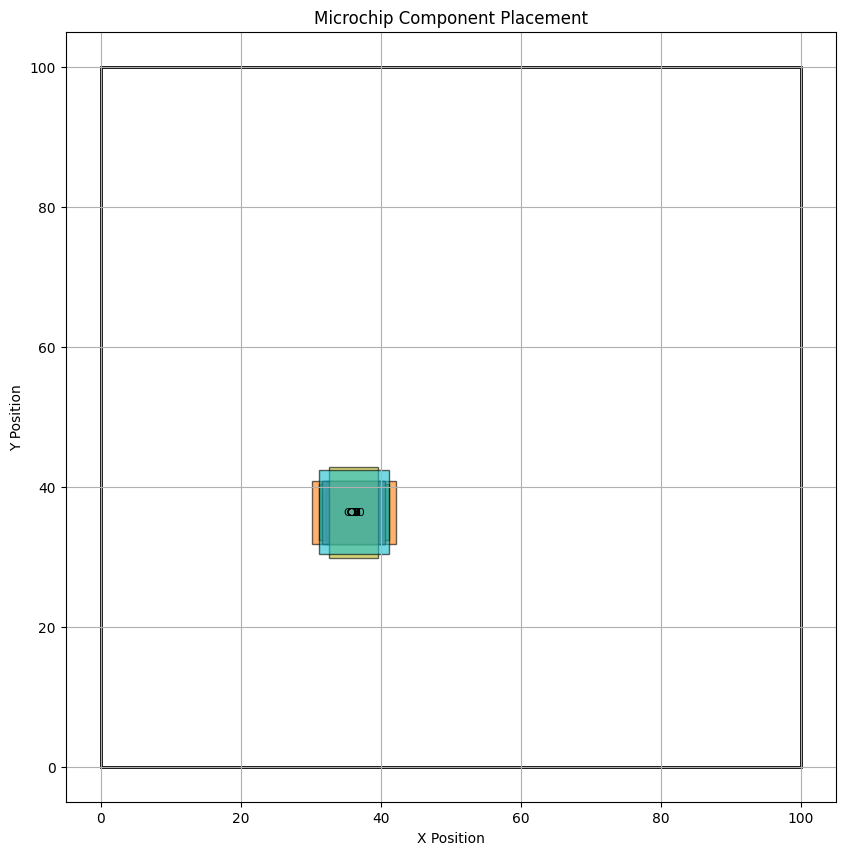

In [ ]:
# Extract solution
solution = {}
for comp in components['Component']:
    solution[comp] = {
        'x': pyo.value(model.x[comp]),
        'y': pyo.value(model.y[comp]),
        'width': component_width[comp],
        'height': component_height[comp]
    }

# Plot the chip and component placements
fig, ax = plt.subplots(figsize=(10, 10))

# Draw chip boundary
chip = patches.Rectangle((0, 0), CHIP_WIDTH, CHIP_HEIGHT, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(chip)

# Define the colormap
colormap = plt.colormaps.get_cmap('tab10')

# Generate colors for each component
colors = [colormap(idx / NUM_COMPONENTS) for idx in range(NUM_COMPONENTS)]

for idx, (comp, data) in enumerate(solution.items()):
    rect = patches.Rectangle((data['x'], data['y']), data['width'], data['height'],
                             linewidth=1, edgecolor='black', facecolor=colors[idx], alpha=0.6)
    ax.add_patch(rect)
    # Annotate component
    ax.text(data['x'] + data['width']/2, data['y'] + data['height']/2, comp,
            horizontalalignment='center', verticalalignment='center', fontsize=8)

# Set axis limits
ax.set_xlim(-5, CHIP_WIDTH + 5)
ax.set_ylim(-5, CHIP_HEIGHT + 5)
ax.set_aspect('equal', adjustable='box')

# Plot title and labels
plt.title('Microchip Component Placement')
plt.xlabel('X Position')
plt.ylabel('Y Position')

# Add gridlines
plt.grid(True)

# Show the plot
plt.show()

# QUBO Script

In [ ]:
!pip install -q pyqubo dwave-ocean-sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.4/157.4 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 123.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 

## Data Generation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pyqubo import Array, Constraint, Placeholder, solve_qubo
from dwave.system import DWaveSampler, EmbeddingComposite
from dimod import ExactSolver

In [ ]:
# Parameters for the chip
CHIP_WIDTH = 100
CHIP_HEIGHT = 100
NUM_COMPONENTS = 3

# Generate synthetic data for components
components = {
    f"C{i}": {"width": np.random.randint(5, 15), "height": np.random.randint(5, 15)}
    for i in range(1, NUM_COMPONENTS + 1)
}

# Create a DataFrame
components_df = pd.DataFrame.from_dict(components, orient='index').reset_index()
components_df.columns = ['Component', 'Width', 'Height']

# Display the DataFrame
print("Synthetic Components Data:")
display(components_df)

Synthetic Components Data:


,Component,Width,Height
0,C1,11,9
1,C2,8,14
2,C3,13,10


## Model Creation

In [ ]:
# QUBO Model: Binary Variables for Each Component Position (x and y grid points)
GRID_SIZE = 3  # Discretize the chip into a smaller grid for placement

# Binary variables for each component position on the grid
x_grid = Array.create('x', shape=(NUM_COMPONENTS, GRID_SIZE), vartype='BINARY')
y_grid = Array.create('y', shape=(NUM_COMPONENTS, GRID_SIZE), vartype='BINARY')

# Cost function to minimize the wire length (squared distance between components)
wire_length_cost = 0

for i in range(NUM_COMPONENTS - 1):
    for j in range(i + 1, NUM_COMPONENTS):
        for k in range(GRID_SIZE):
            for l in range(GRID_SIZE):
                wire_length_cost += (
                    (x_grid[i, k] * x_grid[j, l] * (k - l) ** 2) +
                    (y_grid[i, k] * y_grid[j, l] * (k - l) ** 2)
                )

# Constraint: Ensure that each component is placed at exactly one grid point (x and y)
placement_constraint_x = 0
placement_constraint_y = 0
for i in range(NUM_COMPONENTS):
    placement_constraint_x += (sum(x_grid[i, k] for k in range(GRID_SIZE)) - 1) ** 2
    placement_constraint_y += (sum(y_grid[i, k] for k in range(GRID_SIZE)) - 1) ** 2

# Constraint: Non-overlapping constraints (same grid point should not be shared by more than one component)
non_overlap_constraint = 0
for i in range(NUM_COMPONENTS):
    for j in range(i + 1, NUM_COMPONENTS):
        for k in range(GRID_SIZE):
            non_overlap_constraint += (x_grid[i, k] * x_grid[j, k]) + (y_grid[i, k] * y_grid[j, k])

# Combine the objective and constraints into a QUBO problem
qubo_model = wire_length_cost + Placeholder('lambda') * (placement_constraint_x + placement_constraint_y + non_overlap_constraint)

# Compile the QUBO model
compiled_model = qubo_model.compile()

# Set the value of lambda (penalty term)
feed_dict = {'lambda': 10.0}

# Convert the model into QUBO form
qubo, offset = compiled_model.to_qubo(feed_dict=feed_dict)

## Solver Execution

In [ ]:
# Select a solver: Classical (ExactSolver) or Quantum Solver (DWave)
solver_choice = "classical"  # Change to "quantum" for D-Wave

if solver_choice == "classical":
    solver = ExactSolver()
    sampleset = solver.sample_qubo(qubo)
else:
    sampler = EmbeddingComposite(DWaveSampler())  # Use D-Wave's quantum solver
    sampleset = sampler.sample_qubo(qubo, num_reads=100)

# Get the best solution
best_solution = sampleset.first.sample

# Extract the positions from the solution
solution_x = {f"C{i+1}": np.argmax([best_solution[f'x[{i}][{k}]'] for k in range(GRID_SIZE)]) for i in range(NUM_COMPONENTS)}
solution_y = {f"C{i+1}": np.argmax([best_solution[f'y[{i}][{k}]'] for k in range(GRID_SIZE)]) for i in range(NUM_COMPONENTS)}

## Results Plotting

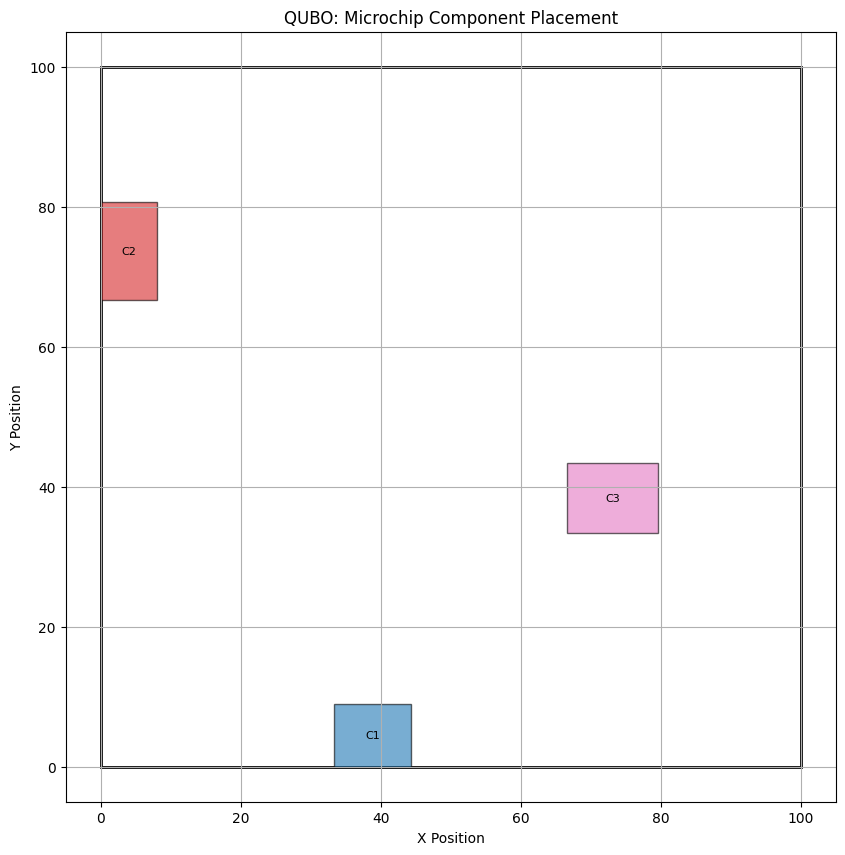

In [ ]:
# Visualization of the placement
fig, ax = plt.subplots(figsize=(10, 10))

# Draw chip boundary
chip = patches.Rectangle((0, 0), CHIP_WIDTH, CHIP_HEIGHT, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(chip)

# Define the colormap
colormap = plt.get_cmap('tab10')

# Generate colors for each component
colors = [colormap(i / NUM_COMPONENTS) for i in range(NUM_COMPONENTS)]

for idx, (comp, position) in enumerate(solution_x.items()):
    width = components[comp]['width']
    height = components[comp]['height']

    rect = patches.Rectangle(
        (position * CHIP_WIDTH / GRID_SIZE, solution_y[comp] * CHIP_HEIGHT / GRID_SIZE),
        width, height, linewidth=1, edgecolor='black', facecolor=colors[idx], alpha=0.6
    )
    ax.add_patch(rect)
    # Annotate component
    ax.text(
        (position * CHIP_WIDTH / GRID_SIZE) + width / 2,
        (solution_y[comp] * CHIP_HEIGHT / GRID_SIZE) + height / 2,
        comp, horizontalalignment='center', verticalalignment='center', fontsize=8
    )

# Set axis limits
ax.set_xlim(-5, CHIP_WIDTH + 5)
ax.set_ylim(-5, CHIP_HEIGHT + 5)
ax.set_aspect('equal', adjustable='box')

# Plot title and labels
plt.title('QUBO: Microchip Component Placement')
plt.xlabel('X Position')
plt.ylabel('Y Position')

# Add gridlines
plt.grid(True)

# Show the plot
plt.show()